In [1]:

import pandas as pd

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import *
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier

from hyperopt import tpe, Trials, hp, STATUS_OK, fmin



data = pd.read_csv("preprocessed.csv", index_col="id")



In [3]:
X = data.drop([
    "cardio",
    # "alco",
    # "smoke",
    # "active", 
    # "age", 
    # "bmi", 
    # "gluc_Normal", 
    # "gluc_Well Above Normal", 
    # "gluc_Above Normal", 
    # "cholesterol_Above Normal", 
    # "cholesterol_Normal", 
    # "cholesterol_Well Above Normal",
    # "ap_hi"
], axis=1)

y = data.filter(["cardio"], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
y_train = y_train.values.ravel()
y_test = y_test.values.ravel()



In [4]:
BEST_ESTIMATORS = {}
TRIAL_HISTORY = {}

# def objective(params):
    
#     n_estimators=int(params["n_estimators"])
#     max_depth=int(params["max_depth"])
    
#     model=RandomForestClassifier(n_estimators=n_estimators,max_depth=max_depth)
#     accuracy = cross_val_score(model, X_train, y_train, cv = 5).mean()

#     return {"loss": -accuracy, "status": STATUS_OK }



# def finetune():    
#     param_space = dict(
#         n_estimators = hp.uniformint("n_estimators", 10, 200),
#         max_depth = hp.uniformint("max_depth", 5, 40),
#     )
    
#     best=fmin(fn=objective,space=param_space,algo=tpe.suggest,trials=Trials(),max_evals=100)
#     return best


# BEST_ESTIMATORS["RandomForestClassifier"] = finetune()
# BEST_ESTIMATORS["RandomForestClassifier"]

In [4]:
# def objective(params):

#     max_depth=params["max_depth"]
#     l2_regularization=params["l2_regularization"]
    
#     model=HistGradientBoostingClassifier(max_depth=max_depth, l2_regularization=l2_regularization)
#     accuracy = cross_val_score(model, X_train, y_train, cv = 5).mean()

#     return {"loss": -accuracy, "status": STATUS_OK }



# def finetune():    
#     param_space = dict(
#         max_depth = hp.uniformint("max_depth", 5, 40),
#         l2_regularization = hp.uniformint("l2_regularization", 0, 20)
#     )
    
#     best=fmin(fn=objective,space=param_space,algo=tpe.suggest,trials=Trials(),max_evals=100)
#     return best

# BEST_ESTIMATORS["HistGradientBoostingClassifier"] = finetune()
# BEST_ESTIMATORS["HistGradientBoostingClassifier"]

In [37]:

def objective(params):

    hidden_layer_sizes=params["hidden_layer_sizes"]
    solver=params["solver"]
    alpha=params["alpha"]
    activation=params["activation"]
    
    model=MLPClassifier(hidden_layer_sizes=hidden_layer_sizes, solver=solver, alpha=alpha, activation=activation, max_iter=1000)
    accuracy = cross_val_score(model, X_train, y_train, cv = 4).mean()

    return {"loss": -accuracy, "status": STATUS_OK }


def finetune():
    from copy import deepcopy
    
    layers = [[20, 20]]
    for i in range(7):
        new_layer = deepcopy(layers[0])
        new_layer.append(20)
        layers.append(new_layer)
        
    trials = Trials()
        
    param_space = dict(
        hidden_layer_sizes = hp.choice("hidden_layer_sizes", layers),
        solver = hp.choice("solver", ["sgd", "adam"]),
        alpha = hp.uniformint("alpha", 0, 20),
        activation = hp.choice("activation", ["logistic", "relu"])
    )
    
    best=fmin(fn=objective,space=param_space,algo=tpe.suggest,trials=trials,max_evals=50)
    return best, trials

best, trials = finetune()
TRIAL_HISTORY["MLPClassifier"] = trials
BEST_ESTIMATORS["MLPClassifier"] = best
BEST_ESTIMATORS["MLPClassifier"]



100%|██████████| 50/50 [17:40<00:00, 21.20s/trial, best loss: -0.7324223602484472]


{'activation': 1, 'alpha': 0.0, 'hidden_layer_sizes': 2, 'solver': 1}

In [38]:
def objective(params):

    n_estimators=params["n_estimators"]
    max_depth=params["max_depth"]
    
    model=GradientBoostingClassifier(n_estimators=n_estimators, max_depth=max_depth)
    accuracy=cross_val_score(model, X_train, y_train, cv = 4).mean()

    return {"loss": -accuracy, "status": STATUS_OK }



def finetune():    
    param_space = dict(
        n_estimators = hp.uniformint("n_estimators", 5, 200),
        max_depth = hp.uniformint("max_depth", 5, 40)
    )
    trials = Trials()
    
    best=fmin(fn=objective,space=param_space,algo=tpe.suggest,trials=trials,max_evals=50)
    return best, trials

best, trials = finetune()
TRIAL_HISTORY["GradientBoostingClassifier"] = trials
BEST_ESTIMATORS["GradientBoostingClassifier"] = best
BEST_ESTIMATORS["GradientBoostingClassifier"]

100%|██████████| 50/50 [1:21:04<00:00, 97.29s/trial, best loss: -0.735175983436853] 


{'max_depth': 6.0, 'n_estimators': 36.0}

In [75]:
def objective(params):

    kernel=params["kernel"]
    C = params["C"]
    
    model=SVC(C=C, kernel=kernel)
    accuracy = cross_val_score(model, X_train, y_train, cv = 4).mean()

    return {"loss": -accuracy, "status": STATUS_OK }



def finetune():    
    param_space = dict(
        C = hp.uniformint("C", 1, 20),
        kernel = hp.choice("kernel", ["linear", "rbf"])
    )
    
    trials = Trials()
    best=fmin(fn=objective,space=param_space,algo=tpe.suggest,trials=trials,max_evals=50)
    return best, trials

best, trials = finetune()
TRIAL_HISTORY["SVC"] = trials
BEST_ESTIMATORS["SVC"] = best
BEST_ESTIMATORS["SVC"]

100%|██████████| 50/50 [4:55:04<00:00, 354.09s/trial, best loss: -0.7341200828157349]  


{'C': 1.0, 'kernel': 1}

In [45]:
from copy import deepcopy
TRIAL_HISTORY_BACKUP = deepcopy(TRIAL_HISTORY)


In [74]:
def inverse_loss(param):
    param['result']['loss'] = -param['result']['loss']
    return param


# for model in TRIAL_HISTORY.keys():
#     TRIAL_HISTORY[model]._trials = list(map(inverse_loss, TRIAL_HISTORY[model]._trials))


# TRIAL_HISTORY["MLPClassifier"]._trials = list(map(inverse_loss, TRIAL_HISTORY["MLPClassifier"]._trials))

# TRIAL_HISTORY["SVC"]._trials = TRIAL_HISTORY_BACKUP["SVC"]._trials
# TRIAL_HISTORY["SVC"]._trials



[{'state': 2,
  'tid': 0,
  'spec': None,
  'result': {'loss': -0.6902484472049689, 'status': 'ok'},
  'misc': {'tid': 0,
   'cmd': ('domain_attachment', 'FMinIter_Domain'),
   'workdir': None,
   'idxs': {'max_depth': [0], 'n_estimators': [0]},
   'vals': {'max_depth': [20.0], 'n_estimators': [13.0]}},
  'exp_key': None,
  'owner': None,
  'version': 0,
  'book_time': datetime.datetime(2023, 4, 9, 5, 26, 49, 341000),
  'refresh_time': datetime.datetime(2023, 4, 9, 5, 27, 7, 439000)},
 {'state': 2,
  'tid': 1,
  'spec': None,
  'result': {'loss': -0.6932712215320911, 'status': 'ok'},
  'misc': {'tid': 1,
   'cmd': ('domain_attachment', 'FMinIter_Domain'),
   'workdir': None,
   'idxs': {'max_depth': [1], 'n_estimators': [1]},
   'vals': {'max_depth': [26.0], 'n_estimators': [184.0]}},
  'exp_key': None,
  'owner': None,
  'version': 0,
  'book_time': datetime.datetime(2023, 4, 9, 5, 27, 7, 441000),
  'refresh_time': datetime.datetime(2023, 4, 9, 5, 32, 12, 902000)},
 {'state': 2,
  'ti

finite loss range -0.7324223602484472 -0.49662525879917185 -0.7307867494824016


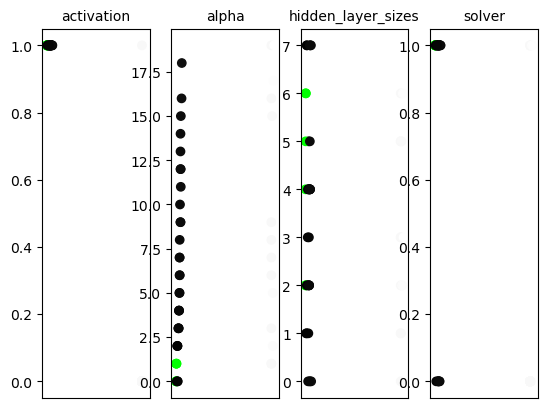

finite loss range -0.735175983436853 -0.6404761904761905 -0.7328778467908902


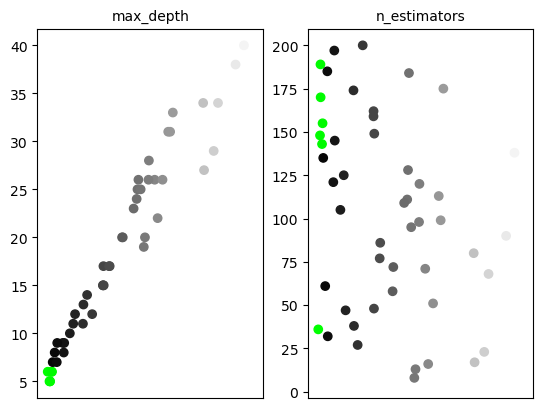

finite loss range -0.7341200828157349 -0.7258592132505176 -0.7339751552795032


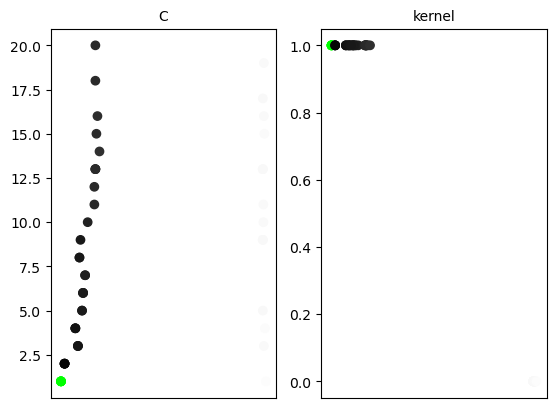

In [76]:
from hyperopt.plotting import *

for model in TRIAL_HISTORY.keys():
    main_plot_vars(TRIAL_HISTORY[model], colorize_best=5, arrange_by_loss=True)



avg best error: -0.7324223602484472


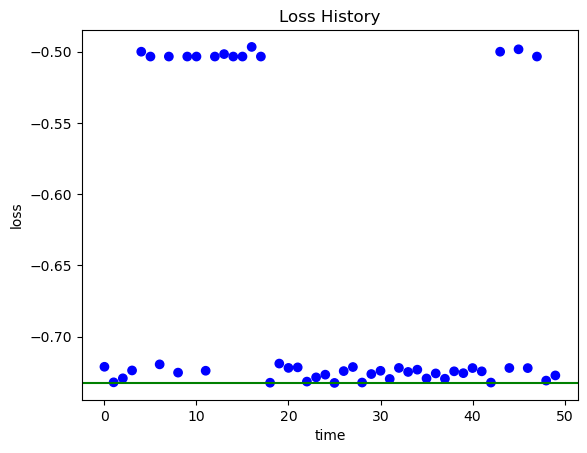

avg best error: -0.735175983436853


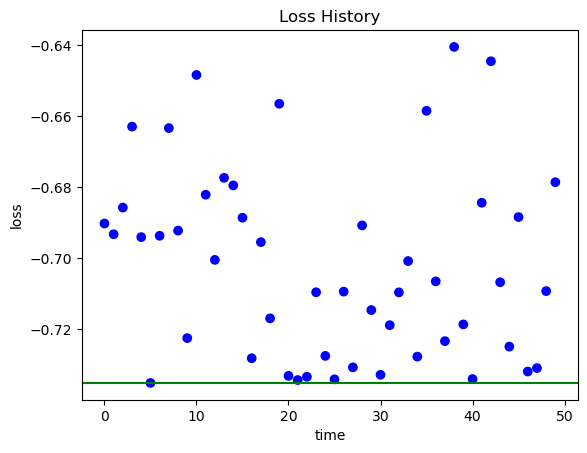

avg best error: -0.7341200828157349


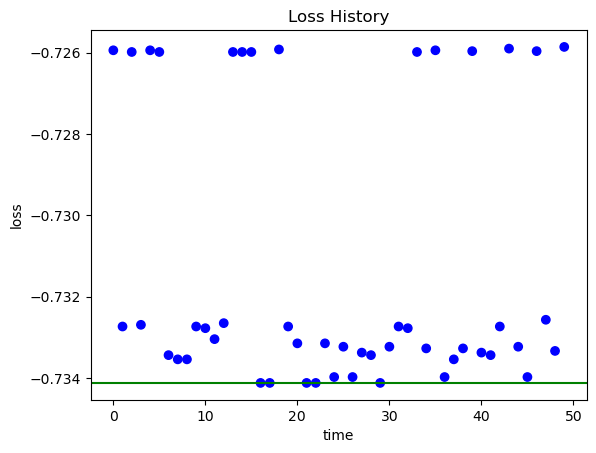

In [77]:
for model in TRIAL_HISTORY.keys():
    main_plot_history(trials=TRIAL_HISTORY[model])

In [ ]:
import numpy as np
import plotly.graph_objs as go
from plotly.subplots import make_subplots
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

max_depths = np.arange(10, 20)
n_estimators = np.arange(30, 50, 10)

# Prepare a grid for storing accuracy scores
accuracy_scores = np.zeros((len(max_depths), len(n_estimators)))

# Evaluate GradientBoostingClassifier with different hyperparameters
for i, max_depth in enumerate(max_depths):
    for j, n_estimator in enumerate(n_estimators):
        model = GradientBoostingClassifier(max_depth=max_depth, n_estimators=n_estimator, random_state=42)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        accuracy_scores[i, j] = accuracy

# Create Plotly heatmap
heatmap = go.Heatmap(
    x=n_estimators,
    y=max_depths,
    z=accuracy_scores,
    colorbar=dict(title="Accuracy"),
    colorscale="Viridis",
)

layout = go.Layout(
    title="GradientBoostingClassifier Hyperparameter Space",
    xaxis=dict(title="n_estimators"),
    yaxis=dict(title="max_depth"),
    autosize=False,
    width=800,
    height=600,
)

fig = go.Figure(data=[heatmap], layout=layout)
fig.show()
